In [2]:
# ==================================================================================================
# Yufei Li
# Princeton University
# yl5385@princeton.edu

# Feburay 2023

# Note:In this demo, the neural network is synthesized using the TensorFlow (verion: 2.11.0) framework. 
# Please install TensorFlow according to the official guidance, then import TensorFlow and other dependent modules.
# ==================================================================================================

!pip install pandas numpy matplotlib
!pip install tensorflow

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple


In [3]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import copy
import csv
import math
import cmath
import time

from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())
inFilename = "P6x_Q1x_input.csv"
outFilename = "P6x_Q1x_processed.csv"

Input = pd.read_csv(inFilename,header=None)
Output = pd.read_csv(outFilename,header=None)

print(Input.dtypes)
print(Output.dtypes)

inputs = []
outputs = []

inputs = np.array(Input)
outputs = np.array(Output)
print(inputs)
print(outputs)

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 10372545384386877922
xla_global_id: -1
]
0    float64
1    float64
2    float64
3    float64
dtype: object
0    float64
1    float64
2    float64
3    float64
4    float64
5    float64
6    float64
7    float64
dtype: object
[[6.00000000e-01 1.00000000e-01 9.00000000e-01 1.00000000e+00]
 [6.00000000e-01 1.00000000e-01 9.00000000e-01 1.31578947e+00]
 [6.00000000e-01 1.00000000e-01 9.00000000e-01 1.75438596e+00]
 ...
 [1.00000000e+00 1.00000000e+00 1.10000000e+00 1.16666667e+02]
 [1.00000000e+00 1.00000000e+00 1.10000000e+00 1.50000000e+02]
 [1.00000000e+00 1.00000000e+00 1.10000000e+00 2.00000000e+02]]
[[-1.89752558e-01  2.68347272e-03 -6.52532768e-03 ...  1.30759830e-04
   1.86864105e-01 -5.32802104e-03]
 [-1.93270379e-01  5.38163551e-03 -6.57970783e-03 ...  7.01189340e-06
   1.87168261e-01 -8.08387520e-03]
 [-1.98163439e-01  1.11955634e-02 -6.57944532e-03 ... -2.33668369e-05
   1.87282997e-01 -

In [4]:
# Randomize the order of the inputs, so they can be evenly distributed for training, testing, and validation

num_inputs = len(inputs)
print("Total Number of Dataset is:",num_inputs)
randomize = np.arange(num_inputs)
print(randomize)

inputs_origin = copy.deepcopy(inputs[randomize])
outputs_origin = copy.deepcopy(outputs[randomize])
print(inputs_origin)

random.Random(5).shuffle(randomize)
print(randomize)
# Swap the consecutive indexes (0, 1, 2, etc) with the randomized indexes
inputs_real = copy.deepcopy(inputs_origin[randomize])
outputs_real = copy.deepcopy(outputs_origin[randomize])
print(inputs_real)
print(outputs_real)

# Split the recordings (group of samples) into two sets: training and testing
TRAIN_SPLIT = int(0.7 * num_inputs)
inputs_train, inputs_test = np.split(inputs_real, [TRAIN_SPLIT])
outputs_train, outputs_test = np.split(outputs_real, [TRAIN_SPLIT])

num_inputs_train = len(inputs_train)
print("Total Number of training Dataset is:",num_inputs_train)
print("Dataset randomization and separation complete!")

Total Number of Dataset is: 3000
[   0    1    2 ... 2997 2998 2999]
[[6.00000000e-01 1.00000000e-01 9.00000000e-01 1.00000000e+00]
 [6.00000000e-01 1.00000000e-01 9.00000000e-01 1.31578947e+00]
 [6.00000000e-01 1.00000000e-01 9.00000000e-01 1.75438596e+00]
 ...
 [1.00000000e+00 1.00000000e+00 1.10000000e+00 1.16666667e+02]
 [1.00000000e+00 1.00000000e+00 1.10000000e+00 1.50000000e+02]
 [1.00000000e+00 1.00000000e+00 1.10000000e+00 2.00000000e+02]]
[2118 2790 2288 ... 1468 1046 2551]
[[  0.9          0.6          0.9        150.        ]
 [  1.           0.7          1.          16.66666667]
 [  0.9          0.9          0.9          9.375     ]
 ...
 [  0.8          0.5          1.           9.375     ]
 [  0.7          0.8          1.           5.35714286]
 [  1.           0.3          1.          21.42857143]]
[[ 4.56377053e-03  1.08869332e-03  4.21313930e-03 ... -1.00284572e-05
  -2.40946988e-02 -1.81104792e-02]
 [-4.33703906e-02  1.82954077e-01 -5.28138932e-02 ... -6.04330570e-04


In [5]:
# build the model and train it
initial_learning_rate = 0.020669824682365133
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
  initial_learning_rate,
  decay_steps=375*65,
  decay_rate=0.575401007701697,
  staircase=True)

Normlayer1=tf.keras.layers.Normalization()
Normlayer1.adapt(inputs_real)

model = tf.keras.Sequential()
model.add(Normlayer1)
model.add(tf.keras.layers.Dense(43, activation='sigmoid'))
model.add(tf.keras.layers.Dense(56, activation='sigmoid'))
model.add(tf.keras.layers.Dense(43, activation='sigmoid'))
model.add(tf.keras.layers.Dense(8))

#Train using Adam
opt = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
model.compile(optimizer=opt, loss='mse', metrics=['mse'])

t2_start = time.perf_counter()
history = model.fit(inputs_train, outputs_train, epochs=3000, batch_size=16, validation_data=(inputs_test, outputs_test))
t2_stop = time.perf_counter()
print("Elapsed time: ", t2_stop - t2_start)

print(model.evaluate(inputs_test, outputs_test, verbose=0))

Epoch 1/3000
132/132 [==============================] - 1s 2ms/step - loss: 0.0113 - mse: 0.0113 - val_loss: 0.0015 - val_mse: 0.0015
Epoch 2/3000
132/132 [==============================] - 0s 1ms/step - loss: 9.4608e-04 - mse: 9.4608e-04 - val_loss: 5.5290e-04 - val_mse: 5.5290e-04
Epoch 3/3000
132/132 [==============================] - 0s 1ms/step - loss: 4.4688e-04 - mse: 4.4688e-04 - val_loss: 4.2150e-04 - val_mse: 4.2150e-04
Epoch 4/3000
132/132 [==============================] - 0s 977us/step - loss: 3.5797e-04 - mse: 3.5797e-04 - val_loss: 2.9245e-04 - val_mse: 2.9245e-04
Epoch 5/3000
132/132 [==============================] - 0s 1ms/step - loss: 2.3156e-04 - mse: 2.3156e-04 - val_loss: 3.4575e-04 - val_mse: 3.4575e-04
Epoch 6/3000
132/132 [==============================] - 0s 1ms/step - loss: 2.0386e-04 - mse: 2.0386e-04 - val_loss: 2.3705e-04 - val_mse: 2.3705e-04
Epoch 7/3000
132/132 [==============================] - 0s 977us/step - loss: 1.7359e-04 - mse: 1.7359e-04 - val_l

[6.0, 4.0]


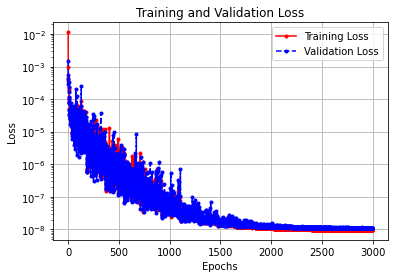

In [11]:
# # increase the size of the graphs. The default size is (6,4).
plt.rcParams["figure.figsize"] = (6,4)

# summarize history for loss
fig, ax = plt.subplots()
plt.plot(history.history['loss'], '-r.', label='Training Loss')
plt.plot(history.history['val_loss'], '--b.', label='Validation Loss')

plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.semilogy()
plt.grid()

fig.savefig('1.svg',dpi=600,format='svg')
print(plt.rcParams["figure.figsize"])
plt.show()
#print(history.history)

In [7]:
Y_input=inputs_origin
Y_pred=model(Y_input, training=False).numpy()
Y_output=outputs_origin
# Save inputs index
with open('P6x_Q1x_ana_inputs.csv','w', newline="") as output_file:
    writer = csv.writer(output_file)
    writer.writerows(Y_input)
# Save predcition from FNN
with open('P6x_Q1x_ana_prediction.csv','w', newline="") as output_file:
    writer = csv.writer(output_file)
    writer.writerows(Y_pred)
# Save original data
with open('P6x_Q1x_ana_outputs.csv','w', newline="") as output_file:
    writer = csv.writer(output_file)
    writer.writerows(Y_output)

In [8]:
# Use the model to predict test data
output_pred = model.predict(inputs_test)
#print(output_pred)
output_diff = output_pred - outputs_test
MSE = np.square(np.subtract(output_pred,outputs_test)).mean()
print(output_diff)
print(MSE)

29/29 [==============================] - 0s 422us/step
[[ 1.61326927e-05  2.54854390e-05 -4.74592881e-05 ... -5.08241895e-06
   9.72794363e-05  8.61687972e-05]
 [ 1.65194792e-04  1.27009023e-05  8.71505628e-05 ... -2.35731262e-05
  -1.27950119e-04  2.50988221e-04]
 [-4.59876231e-05  4.45412886e-05 -1.12516446e-04 ... -4.11916864e-06
   8.00083528e-05 -1.34608676e-05]
 ...
 [-1.91859596e-04  8.64721243e-05  3.40811566e-05 ... -2.55496215e-05
   1.72720981e-04 -1.45266244e-04]
 [-1.22016725e-06 -1.20711687e-04 -3.54096891e-05 ...  8.75243808e-06
  -8.29464805e-05  1.64143817e-05]
 [-5.21827870e-05 -2.30694094e-04  1.30577770e-04 ...  7.61471104e-06
  -2.84735088e-04  1.62429448e-04]]
1.1187132482341051e-08
